# Install packages

In [24]:
%pip install mujoco
%pip install scipy


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Import packages

In [ ]:
# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import numpy as np
from typing import Callable, Optional, Union, List
import scipy.linalg
import math
import time
import copy
import numpy.typing as npt

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

# `MuJoCo`: An Advanced Physics Engine

- `MuJoCo`, which stands for Multi-Joint dynamics with Contact, is a cutting-edge physics engine designed to aid in research and development in various fields, including robotics, biomechanics, graphics, and animation.

- It is renowned for its speed, accuracy, and powerful modeling capabilities, making it a valuable tool for both academic and practical applications.

## Setup the `MuJoCo` environment for simulating and visualizing a Panda robot model.

### `XML` 
- `model` => Used to instantiate an `MjModel`.
- Create an `MjData` which holds the simulation state, and an instance of the `Renderer` class defined above.

### `model` = `mujoco.MjModel`.`from_xml_string(xml)`
- XML로부터 mujoco model을 생성함.
-  **physical properties** -> `kinematics`, and `dynamics`, `Inertia`, `stiffness`, ... of the Panda robot

### `mujoco.MjData(model)`
- Initializes `MuJoCo data object` associated with the model.
- Contains `simulation state`, including `positions`, `velocities`, `forces`, and other dynamic properties.

### `mujoco.Renderer(model)`:
- Initializes the renderer object for visualizing the MuJoCo model.
- Handle the rendering of the model's simulation in a 3D graphical window.

# Load and Render the Franka Emika Panda

In [27]:
# Clone the repository containing the Panda robot model and related assets
!git clone https://github.com/SouthColumn76/panda_mjcf

# Copy the assets directory from the cloned repository to the current working directory
!cp -r panda_mjcf/assets ./assets

# Open and read the XML file defining the Panda robot model
MODEL_FILE = "panda_mjcf/panda.xml"
FINAL_MODEL_FILE = "panda_mjcf/panda_4cube.xml"

with open(FINAL_MODEL_FILE, "r") as fp:
    model_xml = fp.read()

fatal: destination path 'panda_mjcf' already exists and is not an empty directory.


# 1. Initialize `Mujoco` Model

In [28]:
# 1. Model은 Mujoco의 물리 객체 모델
MODEL = mujoco.MjModel.from_xml_string(model_xml)

# 2. Data는 Model의 physical state를 나타내는 객체
MODEL_DATA = mujoco.MjData(MODEL)

# 3. Renderer는 Model을 3D 렌더링하는 객체
renderer = mujoco.Renderer(MODEL)

The state in the `data` object is in the default configuration. Let's invoke the forward dynamics to populate all the derived quantities (like the positions of geoms in the world), update the scene and render it:

### `mujoco`.`mj_forward(model, data)` `-> None`
- computes the **forward dynamics** of the model.
- **updates the state** of the simulation based on the current `positions`, `velocities`, and `forces` acting on the model.
- Advances the simulation **by one time step**, considering the physics and constraints defined in the model.
- Call by reference를 사용함, model, data를 직접 수정함. 

> `mj_forward`를 호출하면 다음 `time_step`에서의 모델 forward kinematics를 계산함

### `renderer`.`update_scene(data)`
- Updates the renderer with the latest simulation data.
- Prepares the scene for rendering by incorporating the current state of the simulation (positions, orientations, etc.) into the graphical representation.

### `renderer`.`render()`:
- Renders the current scene, generating an `image` based on the updated simulation data.
- Produces a visual representation of the model and its environment as defined by the current state.
> 현재 model의 상태 `Image`를 return함

### `media`.`show_image(renderer.render() = Image)`: 
- Displays the rendered image using a media display tool. 
- Takes the image produced by `renderer.render()`
- Shows it in an appropriate viewer, **making the simulation's visual output accessible to the user.**

""

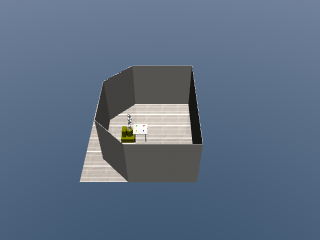

In [29]:
def test_environment_configuration():
    # Perform a forward dynamics computation to update the simulation state
    mujoco.mj_forward(MODEL, MODEL_DATA)

    # Update the renderer with the current simulation data
    renderer.update_scene(MODEL_DATA)

    # Render the current scene and display the resulting image
    media.show_image(renderer.render())


test_environment_configuration()

# 2. Camera of `XML` model

Because it is far away, the robot cannot be seen in detail.

`Mujoco` **can use multiple cameras**.

Check the cameras currently in this XML and render using each one.

frontview


""

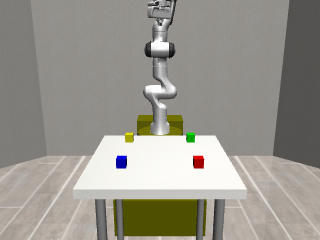

birdview


""

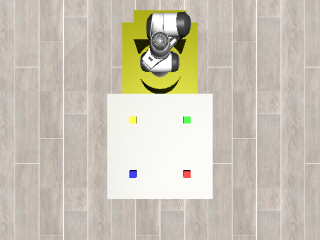

agentview


""

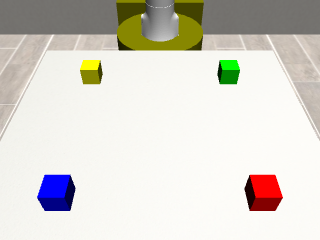

sideview


""

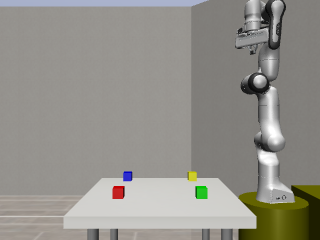

targetview


""

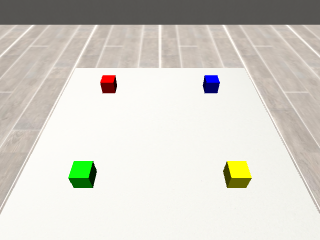

In [30]:
for i in range(MODEL.ncam):
    print(MODEL.camera(i).name)
    renderer.update_scene(MODEL_DATA, camera=i)
    media.show_image(renderer.render())

When specifying a camera, we can use not only the number but also the name.

""

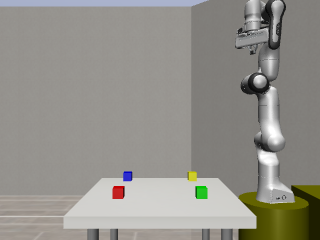

In [31]:
renderer.update_scene(MODEL_DATA, camera="sideview")
media.show_image(renderer.render())

# 3. Actuator Control

### `mj_resetDataKeyframe` can be used to load them. Let's see what they look like:

1. `Keyframes`: **predefined states of the model**
2. `Model`: comes with some built-in `Keyframes` which are saved simulation states.

### `mujoco`.`mj_resetDataKeyframe(model, data, key)`
- Resets simulation data: **to match the state defined by the specified `Keyframe`**.
- Sets the simulation to these states: one by one, as the loop iterates.

""

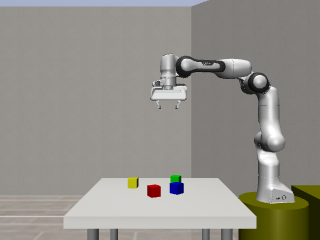

In [32]:
def test_view():
    for key in range(MODEL.nkey):
        mujoco.mj_resetDataKeyframe(MODEL, MODEL_DATA, key)
        mujoco.mj_forward(MODEL, MODEL_DATA)
        renderer.update_scene(MODEL_DATA, camera="sideview")
        media.show_image(renderer.render())


test_view()

Now let's simulate the physics and render to make a video.

In [33]:
def test_video():
    DURATION = 3  # seconds
    FRAMERATE = 60  # Hz

    # Initialize pose.
    mujoco.mj_resetDataKeyframe(MODEL, MODEL_DATA, 0)

    frames = []
    while MODEL_DATA.time < DURATION:
        # Step the simulation.
        mujoco.mj_step(MODEL, MODEL_DATA)

        # Render and save frames.
        if len(frames) < MODEL_DATA.time * FRAMERATE:
            renderer.update_scene(MODEL_DATA, camera="sideview")
            pixels = renderer.render()
            frames.append(pixels)

    # Display video.
    media.show_video(frames, fps=FRAMERATE)


test_video()

Since the model is defined as built-in torque actuators, without control, the posture cannot be maintained due to gravity.

we can use to drive the robot's joints by setting the `data.ctrl` vector.

# 4. `joint` and `actuator`

## Find the relationship between joint, actuator

In `XML`, not only robots but all movable objects have joints.

Among them, the only `joints` that **can be controlled are those connected to the `actuator`**.

To find out which joints an actuator can control, **check the actuator's `transmission type` and `ID`**.

In [34]:
def test_actuator():
    # actuator에 대한 정보를 담고 있음
    first_actuator = MODEL.actuator(0)
    print(first_actuator.name, first_actuator.trntype, first_actuator.trnid)
    MODEL.actuator(0).trntype, MODEL.actuator(0).trnid


test_actuator()

actuator1 [0] [ 4 -1]


## Helper function

In [35]:
def test_id():
    body_id = MODEL.body("link1").id
    joint_id = MODEL.body_jntadr[body_id]
    print(body_id, joint_id)

    for body_id in range(MODEL.nbody):
        print(MODEL.body(body_id).name)


test_id()


def get_body_ids(model: mujoco.MjModel, eef: str | int) -> list[int]:
    """
    Get the body ids of the kinematics chain

    Args:
        model (mujoco.MjModel): mujoco model
        eef (str | int): end effector name or id
    """
    eef_id = model.body(eef).id
    body_ids = [eef_id]
    body_id = eef_id
    tree_id = model.body_treeid[eef_id]
    for _ in range(model.nbody):
        parent_id = model.body(body_id).parentid[0]
        if model.body_treeid[parent_id] == tree_id:
            body_ids.append(parent_id)
            body_id = body_ids[-1]
        else:
            break
    else:
        raise ValueError(f"body {eef_id} not in tree of kinematics chain.")
    body_ids.reverse()
    return body_ids


def get_qpos_adrs(model: mujoco.MjModel, body_ids: list[int]) -> list[int]:
    """
    Get the qpos addresses of the kinematics chain

    Qpos = position of the joint
    ```python
    qpos_adrs = model.jnt_qposadr[jnt_ids]
    ```
    """
    jnt_ids = model.body_jntadr[body_ids]
    jnt_ids = [id for id in jnt_ids if id != -1]
    qpos_adrs = model.jnt_qposadr[jnt_ids]
    return qpos_adrs


def get_qvel_adrs(model: mujoco.MjModel, body_ids: list[int]) -> list[int]:
    """
    Get the qvel addresses of the kinematics chain

    Qvel = velocity of the joint

    ```python
    qvel_adrs = model.jnt_dofadr[jnt_ids]
    ```
    """
    jnt_ids = model.body_jntadr[body_ids]
    jnt_ids = [id for id in jnt_ids if id != -1]
    dof_adrs = model.jnt_dofadr[jnt_ids]
    return dof_adrs


def test_helper() -> None:
    body_ids = get_body_ids(MODEL, eef="hand")
    qpos_adrs = get_qpos_adrs(MODEL, body_ids)
    qvel_adrs = get_qvel_adrs(MODEL, body_ids)
    print(f"\nEnd-effector hand -> qposes: {qpos_adrs}, qvels: {qvel_adrs}\n")
    print(
        "\n".join(
            [
                f"body name: {MODEL.body(body_id).name}, bodt id: {body_id} , qpos adress: {qpos_adrr}, qvel adress: {qvel_adrr}"
                for body_id, qpos_adrr, qvel_adrr in zip(body_ids, qpos_adrs, qvel_adrs)
            ]
        )
    )


test_helper()

13 4
world
table
red_cube
blue_cube
green_cube
yellow_cube
robot_fixed
mount_base
mount0_controller_box
mount_pedestal_feet
mount_torso
mount_pedestal
link0
link1
link2
link3
link4
link5
link6
link7
hand
grasp_site
left_finger
right_finger

End-effector hand -> qposes: [28 29 30 31 32 33 34], qvels: [24 25 26 27 28 29 30]

body name: link1, bodt id: 13 , qpos adress: 28, qvel adress: 24
body name: link2, bodt id: 14 , qpos adress: 29, qvel adress: 25
body name: link3, bodt id: 15 , qpos adress: 30, qvel adress: 26
body name: link4, bodt id: 16 , qpos adress: 31, qvel adress: 27
body name: link5, bodt id: 17 , qpos adress: 32, qvel adress: 28
body name: link6, bodt id: 18 , qpos adress: 33, qvel adress: 29
body name: link7, bodt id: 19 , qpos adress: 34, qvel adress: 30


In [36]:
def test_configuration():
    MODEL.nu  # number of actuators/controls = dim(ctrl)

    joint_ids = []
    ctrl_adrs = []

    for actuator_id in range(MODEL.nu):
        transmission_type = MODEL.actuator(actuator_id).trntype[0]
        is_joint = transmission_type == mujoco.mjtTrn.mjTRN_JOINT

        if is_joint:
            model_joint = MODEL.actuator(actuator_id)
            model_joint_id = model_joint.trnid[0]

            joint_ids.append(model_joint_id)
            ctrl_adrs.append(actuator_id)

    qpos_adrs = MODEL.jnt_qposadr[joint_ids]
    print("Joint IDs:", joint_ids)
    print("Control IDs:", ctrl_adrs)
    print("QPOS(=Joint id) addresses:", qpos_adrs)


test_configuration()


def get_joint_actuator_ids_adress(model: mujoco.MjModel) -> tuple[list[int], list[int]]:
    """
    Get the `joint` IDs & `actuator` Address for the robot model
    """
    joint_ids: list[int] = []
    actuator_addresses: list[int] = []

    for actuator_id in range(model.nu):
        transmission_type = model.actuator(actuator_id).trntype[0]
        is_joint = transmission_type == mujoco.mjtTrn.mjTRN_JOINT

        if is_joint:
            model_joint = model.actuator(actuator_id)
            model_joint_id = model_joint.trnid[0]

            joint_ids.append(model_joint_id)
            actuator_addresses.append(actuator_id)

    return joint_ids, actuator_addresses


def get_joint_qpos_addresses(model: mujoco.MjModel, joint_ids: list[int]) -> list[int]:
    """
    Get the `qpos` = joint_pose addresses for the robot model

    Args:
        joint_ids: List of joint IDs

    Example:
    ```python
    # First, get the joint and actuator IDs
    joint_ids, actuator_ids = get_joint_actuator_ids()

    # Next, get the qpos addresses for the joint IDs
    qpos_adrs = get_joint_qpos_addresses(joint_ids)
    ```
    """
    qpos_adrs = model.jnt_qposadr[joint_ids]
    return qpos_adrs

Joint IDs: [4, 5, 6, 7, 8, 9, 10]
Control IDs: [0, 1, 2, 3, 4, 5, 6]
QPOS(=Joint id) addresses: [28 29 30 31 32 33 34]


## In this `XML`

1. `mjTRN_JOINT`: transmission type of each joint of the robot
2. `mjTRN_TENDON`: the finger of the end-effector

In [37]:
# Joint의 종류
# 1. Revolute joint
# 2. Tendon joint
# 2가지는 gripper에 대한 디자인

mujoco.mjtTrn.mjTRN_JOINT, mujoco.mjtTrn.mjTRN_TENDON

(<mjtTrn.mjTRN_JOINT: 0>, <mjtTrn.mjTRN_TENDON: 3>)

# 5. `PID` Controller Class

Implement a PID (Proportional-Integral-Derivative) Controller class in Python to control a system. The PID controller should be capable of updating its control output based on the current state of the system, the target state, and the elapsed time. The controller should include features like anti-windup and output smoothing using Exponential Moving Average (EMA).

**Specifications**:

1. Class Definition:
  - Class Name: `PIDController`
2. Constructor Parameters:
  - `k_p`: Proportional gain (default: 0.01)
  - `k_i`: Integral gain (default: 0.0)
  - `k_d`: Derivative gain (default: 0.001)
  - `dt`: Time step (default: 0.01)
  - `dim`: Dimensionality of the controller (default: 1)
  - `dt_min`: Minimum time step to avoid division by zero (default: 1e-6)
  - `out_min`: Minimum output value (default: -infinity)
  - `out_max`: Maximum output value (default: infinity)
  - `ANTIWU`: Boolean to enable or disable anti-windup (default: True)
  - `out_alpha`: Smoothing factor for output EMA (default: 0.0)
3. Methods:
  - `reset(self, t_curr=0.0)`: Resets the internal state of the controller.
  - `update(self, x_curr, t_curr, x_trgt=None)`: Updates the controller state and computes the control output based on the current and target states and the current time.
  - `out(self)`: Returns the current control output value.
4. Functional Requirements:

  - The controller should compute the control output using the PID formula:

### $$u(t)=K_{p}e(t)+K_{i}\int e(t)dt+K_{d} \frac{de(t)}{dt}$$

  - Implement anti-windup to prevent the integral term from accumulating excessively.
  - Smooth the control output using an Exponential Moving Average (EMA) if out_alpha is greater than 0.
  - Ensure the output value is clipped within the specified out_min and out_max range.

In [38]:
class PIDController:
    def __init__(
        self,
        k_p=0.01,
        k_i=0.0,
        k_d=0.001,
        dt=0.01,
        dim=1,
        dt_min=1e-6,
        out_min=-np.inf,
        out_max=np.inf,
        ANTIWU=True,  # anti-windup
        out_alpha=0.0,  # output EMA (0: no EMA)
    ) -> None:
        self.k_p = np.ones(shape=dim) * k_p
        self.k_i = np.ones(shape=dim) * k_i
        self.k_d = np.ones(shape=dim) * k_d
        self.dt = dt
        self.dim = dim
        self.dt_min = dt_min
        self.out_min = out_min
        self.out_max = out_max
        self.ANTIWU = ANTIWU
        self.out_alpha = out_alpha

        # Buffers
        self.reset()

    def reset(self, t_curr=0.0) -> None:
        self.cnt = 0
        self.x_trgt = np.zeros(shape=self.dim)
        self.x_curr = np.zeros(shape=self.dim)
        self.out_val = np.zeros(shape=self.dim)
        self.out_val_prev = np.zeros(shape=self.dim)
        self.t_curr = t_curr
        self.t_prev = t_curr
        self.err_curr = np.zeros(shape=self.dim)
        self.err_intg = np.zeros(shape=self.dim)
        self.err_prev = np.zeros(shape=self.dim)
        self.p_term = np.zeros(shape=self.dim)
        self.d_term = np.zeros(shape=self.dim)
        self.err_out = np.zeros(shape=self.dim)

    def update(self, x_curr, t_curr, x_trgt=None) -> None:
        """
        Update PID controller
        u(t) = K_p e(t) + K_i int e(t) {dt} + K_d {de}/{dt}
        """
        if x_trgt is not None:
            self.x_trgt = x_trgt
        if t_curr is not None:
            self.t_curr = t_curr
        if x_curr is not None:
            self.x_curr = x_curr
            # PID controller updates here
            self.dt = max(self.t_curr - self.t_prev, self.dt_min)
            self.err_curr = self.x_trgt - self.x_curr
            self.err_intg = self.err_intg + (self.err_curr * self.dt)
            self.err_diff = self.err_curr - self.err_prev

            if self.ANTIWU:  # anti-windup
                self.err_out = self.err_curr * self.out_val
                self.err_intg[self.err_out < 0.0] = 0.0

            if self.dt > self.dt_min:
                self.p_term = self.k_p * self.err_curr
                self.i_term = self.k_i * self.err_intg
                self.d_term = self.k_d * self.err_diff / self.dt
                self.out_val = np.clip(
                    a=self.p_term + self.i_term + self.d_term,
                    a_min=self.out_min,
                    a_max=self.out_max,
                )
                # Smooth the output control value using EMA
                self.out_val = (
                    self.out_alpha * self.out_val_prev
                    + (1.0 - self.out_alpha) * self.out_val
                )
                self.out_val_prev = self.out_val

            # Backup
            self.t_prev = self.t_curr
            self.err_prev = self.err_curr
        # Counter
        if (t_curr is not None) and (x_curr is not None):
            self.cnt = self.cnt + 1

    def out(self) -> npt.NDArray:
        return self.out_val

### Current status of robot `joints` required to use the `PID controller` can be known through `data.qpos`.

### `data.qpos`: **state vector** of all joints in `XML`

> need to find the `qpos` of the joints connected to the actuator.

In [39]:
def test_pid():
    DURATION = 2  # seconds
    FRAMERATE = 60  # Hz

    # !TODO: 완전히 초기화된 상태
    # Initialize pose.
    mujoco.mj_resetDataKeyframe(MODEL, MODEL_DATA, 0)

    joint_ids, actuator_addresses = get_joint_actuator_ids_adress(MODEL)
    qpos_adrs = get_joint_qpos_addresses(MODEL, joint_ids)

    # Initialize PID Controller
    PID = PIDController(
        k_p=1000,
        k_i=0.1,
        k_d=50,
        dim=7,
        out_min=MODEL.actuator_ctrlrange[actuator_addresses, 0],
        out_max=MODEL.actuator_ctrlrange[actuator_addresses, 1],
    )
    PID.x_trgt = MODEL_DATA.qpos[qpos_adrs].copy()
    PID.x_trgt = np.array([0, 0, 0, -1.571, 0, 4.71, -0.785])

    frames = []

    while MODEL_DATA.time < DURATION:
        # Step the simulation.
        x_curr = MODEL_DATA.qpos[qpos_adrs].copy()

        # Calculate the control
        PID.update(x_curr, MODEL_DATA.time)

        # Control the robot
        # !TODO: ctrl를 통해서 actuator를 제어한다.
        MODEL_DATA.ctrl[actuator_addresses] = PID.out()

        # Update robot state and simulate
        # !TODO: mj_step은 call-by-reference로 data를 다음 상태로 시뮬레이션 한다.
        mujoco.mj_step(MODEL, MODEL_DATA)

        # Render and save frames for video
        if len(frames) < MODEL_DATA.time * FRAMERATE:
            renderer.update_scene(MODEL_DATA, camera="sideview")
            pixels = renderer.render()
            frames.append(pixels)

    # Display video.
    media.show_video(frames, fps=FRAMERATE)


test_pid()

# 7. Path Planning
# 7. Kinematics in `Mujoco`, 

Generate trajectory (`S` - `[0,1]`)

#### Robot `body` & `joint` are important in kinematics.
#### Like actuators, `bodies` also **have a relationship with `joints`**.

Since `mujoco` **represent the relationship** between each `body` as a `kinematic tree`

we can easily find the entire `body` and `joint` using the `body id` or `name` of the end-effector.

Three components are required to create an RRT* planner and a Cartesian planner.

### * `Sampler`:  
  #### `RRT*` is a sampling-based planner, so it requires the ability to generate random samples. Additionally, it serves to check whether the given state is valid.
### * `Collision Checker`:  
  #### It is necessary to check whether a conflict occurs in a given state.
### * `Kinematics`:  
  #### It is responsible for calculating forward and inverse kinematics.

# 7.1 `Sampler`

#### Uniformly parsing `joint` configuration

In [40]:
class Sampler:
    """
    Sampling random configuration for mujoco model
    """

    def __init__(self, model: mujoco.MjModel, body_ids: list[int]) -> None:
        """
        Sampling configuration for mujoco model

        Args:
            model(`mujoco.MjModel`): mujoco model
            body_ids(`list[int]`): list of body ids
        """
        joint_mins = []
        joint_maxs = []
        for id in body_ids:
            joint_id = model.body(id).jntadr[0]
            if joint_id == -1:
                continue
            joint_range = model.joint(joint_id).range
            joint_mins.append(joint_range[0])
            joint_maxs.append(joint_range[1])

        self.joint_mins = np.array(joint_mins)
        self.joint_maxs = np.array(joint_maxs)

    def __call__(self) -> npt.NDArray:
        """
        Uniformly sample a random configuration
        RRT에서 사용할 random configuration을 샘플링한다.
        """
        return np.random.uniform(low=self.joint_mins, high=self.joint_maxs)

    def __contains__(self, item: npt.NDArray) -> bool:
        return np.all((item >= self.joint_mins) & (item <= self.joint_maxs))

In [41]:
def test_sampler() -> Sampler:
    body_ids = get_body_ids(MODEL, eef="hand")
    sampler = Sampler(MODEL, body_ids)

    # Call samples
    sample = sampler()
    print(sample)

    # Pick a random sample
    sample += np.random.normal(0, 1, sample.shape)
    print(sample in sampler)

    return sampler


test_sampler()

[-0.935 -0.841 -1.755 -2.49   2.875  0.172 -2.104]
False


## Get image of position

""

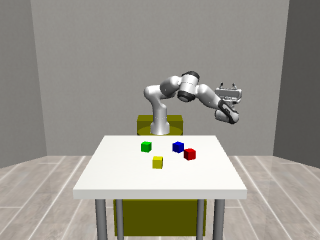

In [42]:
def get_image_of_pos(qpos, camera: str | int = "frontview"):
    qpos_adrs = get_qpos_adrs(
        model=MODEL,
        body_ids=get_body_ids(MODEL, eef="hand"),
    )
    MODEL_DATA.qpos[qpos_adrs] = qpos
    mujoco.mj_kinematics(MODEL, MODEL_DATA)
    renderer.update_scene(MODEL_DATA, camera=camera)
    return renderer.render()


def test_image_of_pos():
    body_ids = get_body_ids(MODEL, eef="hand")
    sampler = Sampler(MODEL, body_ids)

    sample = sampler()
    sample += np.random.normal(0, 1, sample.shape)

    media.show_image(get_image_of_pos(sample))


test_image_of_pos()

# 7.2 `Collision Checker`


### **Specifications**:
#### 1. Class Definition:
- Class Name: `CollisionChecker`

#### 2. Constructor Parameters:
- `model`: An instance of `mujoco`.`MjModel` representing the `MuJoCo` model.
- `body_ids`: A list of `body IDs` to consider for collision checking.
- `ignore_pairs`: An optional list of tuples, each containing `two geometry names` to **ignore during collision detection.**

#### 3. Methods:
- `__init__(self, model: mujoco.MjModel, body_ids: list[int], ignore_pairs: list[tuple] = None)`: Initializes the collision checker with the given model, body IDs, and ignore pairs.
- `set_qpos(self, data: mujoco.MjData)`: Updates the internal state of the collision checker with the given simulation data.
- `__call__(self, sample: npt.NDArray, print_col: bool = False) -> bool`: Checks for collisions given a sample configuration and optionally prints collision details.

#### 4. Functional Requirements:
- The collision checker should update the model's configuration using the provided sample.
- Perform collision detection using MuJoCo's collision functions.
- Optionally ignore specified pairs of geometries during collision detection.
- Optionally print details of collisions if specified.
- Return a boolean indicating whether a collision was detected (excluding ignored pairs).

In [43]:
class CollisionChecker:
    """
    Collision checker for `Mujoco` model
    """

    def __init__(
        self,
        model: mujoco.MjModel,
        body_ids: list[int],
        ignore_pairs: list[tuple] = None,
    ) -> None:
        """
        Mujoco model collision checker (Mujoco `API` based)

        Args:
            model(`mujoco.MjModel`): Mujoco model
            body_ids(`list[int]`): list of body ids
            ignore_pairs(`list[tuple]`): list of ignore pairs
        """
        # Initialize the model
        self.model = model
        # Initialize the data for the simulation
        self.model_data = mujoco.MjData(model)
        # Get the joint positions associated with the body IDs
        self.qpos_adrs = get_qpos_adrs(model, body_ids)
        # Initialize the ignore flag
        self.ignore = False
        # If ignore pairs are provided
        if ignore_pairs:
            # Set the ignore flag to True
            self.ignore = True
            # Convert ignore pairs to sets of geometry IDs
            self.ignore_pairs = [
                set((model.geom(first).id, model.geom(second).id))
                for first, second in ignore_pairs
            ]

    def set_qpos(self, data: mujoco.MjData) -> None:
        """
        Set the joint positions of the Mujoco model to the given data
        """
        self.model_data.qpos[:] = data.qpos.copy()

    def __call__(self, sample: npt.NDArray, print_col: bool = False) -> bool:
        """
        Check if the robot is in collision with the environment

        Args:
            sample(`npt.NDArray`): joint position, Panda 7JOINT (7DOF)
            print_col(`bool`): print collision details, default is `False`
        """
        # Set the joint positions to the given sample
        self.model_data.qpos[self.qpos_adrs] = sample

        # Perform kinematics computations
        mujoco.mj_kinematics(self.model, self.model_data)
        # Check for collisions
        mujoco.mj_collision(self.model, self.model_data)
        # Get the number of contacts
        number_of_contacts = self.model_data.ncon

        # Print collision details if requested
        if print_col:
            print(f"Contacted body counts: {number_of_contacts}")
            for contact in self.model_data.contact:
                print(
                    "Collied between",
                    f"{self.model.body(self.model.geom(contact.geom1).body).name} : {self.model.geom(contact.geom1).name} and",
                    f"{self.model.body(self.model.geom(contact.geom2).body).name} : {self.model.geom(contact.geom2).name}",
                )

        # If ignoring specific pairs of contacts
        if self.ignore:
            for contact in self.model_data.contact:
                pair = set((contact.geom1, contact.geom2))
                if pair in self.ignore_pairs:
                    number_of_contacts -= 1

        # Return True if there are any contacts, False otherwise
        return number_of_contacts != 0

### Ignore pairs

```python
ignore_pairs = [("object_collision", "table_collision")]
```

무시할 object를 정의할 수 있다.

In [44]:
def test_collision():
    ignore_pairs = [("object_collision", "table_collision")]
    body_ids = get_body_ids(MODEL, eef="hand")
    collision = CollisionChecker(MODEL, body_ids)
    # collision.ignore_pairs = ignore_pairs

    sampler = Sampler(MODEL, body_ids)
    sample = sampler()
    sample += np.random.normal(0, 1, sample.shape)

    print(sample, not collision(sample, print_col=True))


# test_collision()

# 7.3 `Kinematics`

Use jacobian when doing inverse. In this case, `dof_adrs` must be used, because the qpos size of the free joint is 7, but the qvel size is 6. mujoco jacobian uses dof adrs because it deals with velocity values.
For reference, the total number of qpos is `model.nq` and the total number of qvel is `model.nv`.

In [45]:
def rot_to_omega(R, threshold):
    el = np.array([[R[2, 1] - R[1, 2]], [R[0, 2] - R[2, 0]], [R[1, 0] - R[0, 1]]])
    norm_el = np.linalg.norm(el)
    if norm_el > threshold:
        w = np.dot(np.arctan2(norm_el, np.trace(R) - 1) / norm_el, el)
    elif R[0, 0] > 0 and R[1, 1] > 0 and R[2, 2] > 0:
        w = np.zeros((3, 1))
    else:
        w = np.dot(np.pi / 2, np.array([[R[0, 0] + 1], [R[1, 1] + 1], [R[2, 2] + 1]]))
    return w


def calc_pose_error(target_pos, target_rot, current_pos, current_rot, threshold):
    pos_diff = target_pos - current_pos
    rot_diff = np.dot(current_rot.T, target_rot)
    w_err = np.dot(current_rot, rot_to_omega(rot_diff, threshold))
    return np.vstack((pos_diff.reshape([-1, 1]), w_err))


class Kinematics:
    """
    Kinematics class for forward and inverse kinematics
    """

    def __init__(self, model: mujoco.MjModel, body_ids: list[int]) -> None:
        """
        Kinematics class for forward

        Args:
            model (`mujoco.MjModel`): Mujoco model
            body_ids (`list[int]`): list of body ids
        """
        self.model = model
        self.body_ids = body_ids

    def forward(self, qpos: npt.NDArray, eef_id: int = None) -> npt.NDArray:
        """
        Forward kinematics solve call

        Args:
            qpos (`npt.NDArray`): joint position
            eef_id (`int`): end effector id
        """
        body_ids = self.body_ids
        if eef_id:
            body_ids = self.get_sub_body_ids(eef_id)
        qpos_adrs = get_qpos_adrs(self.model, body_ids)
        if len(qpos_adrs) != len(qpos):
            raise ValueError(
                f"shape mismatch: qpos array of shape {qpos.shape} could not be broadcast to qpos addresses of shape ({len(qpos_adrs)},)"
            )

        fk_data = mujoco.MjData(self.model)
        fk_data.qpos[qpos_adrs] = qpos

        mujoco.mj_forward(self.model, fk_data)

        pos = fk_data.body(body_ids[-1]).xpos.copy()
        quat = fk_data.body(body_ids[-1]).xquat.copy()
        rot = fk_data.body(body_ids[-1]).xmat.reshape([3, 3]).copy()

        return pos, quat, rot

    def inverse(
        self,
        init_qpos: npt.NDArray,
        goal_pos: npt.NDArray,
        goal_rot: npt.NDArray,
        eef_id: int = None,
        max_iter: int = 10,
        threshold: float = 1e-8,
    ) -> npt.NDArray:
        """
        Inverse kinematics solve call

        Args:
            init_qpos (`npt.NDArray`): initial joint position
            goal_pos (`npt.NDArray`): goal position
            goal_rot (`npt.NDArray`): goal rotation
            eef_id (`int`): end effector id
            max_iter (`int`): maximum iteration
            threshold (`float`): threshold value
        """
        body_ids = self.body_ids
        if eef_id:
            body_ids = self.get_sub_body_ids(eef_id)
        qpos_adrs = get_qpos_adrs(self.model, body_ids)
        if len(qpos_adrs) != len(init_qpos):
            raise ValueError(
                f"shape mismatch: qpos array of shape {init_qpos.shape} could not be broadcast to qpos addresses of shape ({len(qpos_adrs)},)"
            )
        # Jacobian address
        qvel_adrs = get_qvel_adrs(self.model, body_ids)

        dof = self.get_total_dof_of_body_ids(body_ids)
        nv = self.model.nv
        wn_pos = 1 / 0.3
        wn_ang = 1 / (2 * np.pi)
        We = np.diag([wn_pos, wn_pos, wn_pos, wn_ang, wn_ang, wn_ang])
        Wn = np.eye(dof)

        current_qpos = init_qpos.copy()
        ik_data = mujoco.MjData(self.model)
        ik_data.qpos[qpos_adrs] = current_qpos
        mujoco.mj_forward(self.model, ik_data)
        current_pos = ik_data.body(body_ids[-1]).xpos.copy()
        current_rot = ik_data.body(body_ids[-1]).xmat.copy().reshape([3, 3])
        err = calc_pose_error(goal_pos, goal_rot, current_pos, current_rot, threshold)
        Ek = np.dot(np.dot(err.T, We), err)[0][0]

        # Jacobian matrix store
        # 1. Position Jacobian
        jacp = np.zeros((3, nv))
        # 2. Rotation Jacobian
        jacr = np.zeros((3, nv))

        for _ in range(max_iter):
            lamb = Ek + 0.002

            # Compute Jacobian -> Mujoco API -> Save jacp, jacr
            mujoco.mj_jac(self.model, ik_data, jacp, jacr, current_pos, body_ids[-1])

            # Reshape Jacobian
            J = np.vstack(
                [
                    jacp[:, qvel_adrs[0] : qvel_adrs[0] + dof],
                    jacr[:, qvel_adrs[0] : qvel_adrs[0] + dof],
                ]
            )
            # Damped Least Squares Inverse
            JT = np.dot(np.dot(J.T, We), J)
            J_dls = JT + np.dot(np.diag(np.diag(JT)), lamb)

            gerr = np.dot(np.dot(J.T, We), err)
            dq = np.dot(np.linalg.inv(J_dls), gerr)
            current_qpos += dq.reshape([-1])

            ik_data.qpos[qpos_adrs] = current_qpos
            mujoco.mj_forward(self.model, ik_data)
            current_pos = ik_data.body(body_ids[-1]).xpos.copy()
            current_rot = ik_data.body(body_ids[-1]).xmat.copy().reshape([3, 3])
            err = calc_pose_error(
                goal_pos, goal_rot, current_pos, current_rot, threshold
            )
            Ek2 = np.dot(np.dot(err.T, We), err)[0][0]
            if Ek2 <= threshold:
                print(Ek)
                break
            elif Ek2 < Ek:
                Ek = Ek2
            else:
                current_qpos -= dq.reshape([-1])
                print(Ek)
                break
        else:
            current_qpos = None
        return current_qpos

    def get_sub_body_ids(self, eef_id: int) -> list[int]:
        """
        Get the body ids of the kinematics chain of the given `end-effector`'s `id`

        Args:
            ee_id (`int`): end-effector id

        Returns:
            `list[int]`: list of body ids
        """
        body_ids = [eef_id]
        body_id = eef_id
        for _ in range(self.model.nbody):
            parent_id = self.model.body(body_id).parentid
            body_ids.append(parent_id[0])
            body_id = body_ids[-1]
            if body_id == self.body_ids[0]:
                break
        else:
            raise ValueError(f"body {eef_id} not in tree of kinematics chain.")
        body_ids.reverse()
        return body_ids

    def get_total_dof_of_body_ids(self, body_ids: list[int]) -> int:
        """
        Get the total DOF of the given body ids

        Args:
            body_ids (`list[int]`): list of body ids

        Returns:
            `int`: total DOF
        """
        dof = 0
        for jnt_id in self.model.body_jntadr[body_ids]:
            if jnt_id == -1:
                continue
            jnt_type = self.model.jnt(jnt_id).type
            if jnt_type[0] == mujoco.mjtJoint.mjJNT_FREE.value:
                dof += 7
            elif jnt_type[0] == mujoco.mjtJoint.mjJNT_BALL.value:
                dof += 4
            else:
                dof += 1
        return dof

In [46]:
def test_kinematics():
    body_ids = get_body_ids(MODEL, eef="hand")
    kinematics = Kinematics(MODEL, body_ids)

    sampler = Sampler(MODEL, body_ids)
    sample = sampler()
    print(f"before: {sample}")

    pos, _, rot = kinematics.forward(sample)
    sample += np.random.normal(0, 0.1, sample.shape)

    if sample in sampler:
        inversed = kinematics.inverse(sample, pos, rot)
        print(f"after:  {inversed}")
    else:
        print("not in valid joint range")


test_kinematics()

before: [-2.209  0.02  -0.519 -0.796  0.582  1.74   1.56 ]
7.932055746656047e-08
after:  [-2.151  0.022 -0.581 -0.795  0.586  1.739  1.559]


# 7.4 `RRT* Planner`

### `ETA` 를 감소시키면, `step_size`가 많아지므로, 부드러워진다. 중요함

### **Specifications**:

### 1. **Class Definition**:
- **Class Name**: `RRTStarPlanner`

### 2. **Constructor Parameters**:
- `gamma`: A parameter that influences the **radius**(= Boundary of neighborhood) of the search for nearby nodes during the rewiring process.
- `eta`: The maximum step size for the tree expansion.
- `epsilon`: Probability of sampling the goal configuration directly.
> `epsilon` 확률에 따라 random sample이 아닌 goal에 가까운 sampling point를 선택

### 3. **Methods**:
- `__init__(self, gamma: float, eta: float, epsilon: float = 0.0)`: Initializes the planner with the given parameters.
- `__call__(self, sampler: Sampler, collision: CollisionChecker, init_qpos: npt.NDArray, goal_qpos: npt.NDArray, max_iter: int = 1000, threshold: float = 0.5)`: Runs the RRT* algorithm to find a path from `init_qpos` to `goal_qpos`.
- `steer(self, nearest: npt.NDArray, sample: npt.NDArray, distance: float) -> npt.NDArray`: Steers from the nearest configuration towards the sample configuration within the step size limit.
- `path(self) -> list[npt.NDArray]`: Returns the found path as a list of configurations if a path has been found.

### 4. **Functional Requirements**:
- The planner should sample configurations from the configuration space and check for collisions.
- It should steer from the nearest node in the tree towards the sampled configuration, respecting the maximum step size.
- It should rewire the tree to ensure the minimum-cost path.
- It should handle both reaching the goal configuration and ensuring the path is within a specified threshold distance from the goal.


In [47]:
class RRTStarPlanner:
    def __init__(self, gamma: float, eta: float, epsilon: float = 0.0) -> None:
        """
        RRT* Path Planner

        Args:
            gamma (`float`): search boundary(radius)
            eta (`float`): maximum step size
            epsilon (`float`): probability of choosing the goal directly
        """
        # Initialize parameters
        self.gamma: float = gamma
        self.eta: float = eta
        self.epsilon: float = epsilon
        # Flag to check if path is ready,
        # [Initial -> Goal]이 가능한지 확인 하는 상태
        self.path_ready: bool = False

    def __call__(
        self,
        sampler: Sampler,
        collision: CollisionChecker,
        init_qpos: npt.NDArray,
        goal_qpos: npt.NDArray,
        max_iter: int = 1000,
        threshold: float = 0.5,
    ) -> None:
        """
        RRT* Path Planner solve

        Find path `init_qpos` to `goal_qpos`

        Args:
            sampler (`Sampler`): Sampler object
            collision (`CollisionChecker`): Collision checker object
            init_qpos (`npt.NDArray`): initial joint position
            goal_qpos (`npt.NDArray`): goal joint position
            max_iter (`int`): maximum iteration of RRt*, default is 1000
            threshold (`float`): goal threshold, if the distance is less than the threshold, the goal is reached
        """
        # Initialize data buffers, tree structures
        self.samples = np.array([init_qpos.copy()])
        self.parents = np.array([-1], dtype=np.int32)
        self.costs = np.array([0], dtype=np.float64)

        self.path_ready = False

        # Main loop for the planner
        for _ in range(max_iter):
            # Sampling
            if np.random.random() < self.epsilon:
                # 1. epsilon 확률 이하 -> goal을 sampling
                new_qpos = goal_qpos.copy()
            else:
                # 2. epsilon 확률 이상 -> random sampling을 Sampler를 통해 진행한다.
                new_qpos = sampler()

            ## 3. sampling한 qpos가 valid한지 확인
            if collision(new_qpos):
                ## 4. collision이 발생하면 다시 sampling
                continue

            ## 5. nearest sample을 찾고, 새로운 sample로 steer
            distances = np.linalg.norm(self.samples - new_qpos, axis=1)

            nearest_node_index = np.argmin(distances)

            new_qpos = self.steer(
                self.samples[nearest_node_index],
                new_qpos,
                distances[nearest_node_index],
            )

            if new_qpos not in sampler:
                continue
            if collision(new_qpos):
                continue

            ## 6. 이웃한 node들을 찾아서, radius(cost)를 계산하고, 최소 radius(cost) 가지는 node를 near_indices에 저장
            # Connect along a minimum-cost path
            distances = np.linalg.norm(self.samples - new_qpos, axis=1)
            card = len(self.samples) + 1
            radius: float = self.gamma * (
                (math.log(card) / card) ** (1 / len(new_qpos))
            )
            radius: float = min(radius, self.eta)
            near_indices = np.where(np.around(distances, decimals=5) <= radius)[0]

            # 7. Rewire the tree
            near_costs = distances[near_indices] + self.costs[near_indices]
            min_cost = np.min(near_costs)
            min_index = near_indices[np.argmin(near_costs)]
            self.samples = np.vstack((self.samples, new_qpos))
            self.parents = np.append(self.parents, min_index)
            self.costs = np.append(self.costs, min_cost)

            # 8. update all costs
            need_update = np.where(
                distances[near_indices] + min_cost < self.costs[near_indices]
            )[0]
            self.parents[need_update] = len(self.parents) - 1
            self.costs[need_update] = distances[need_update] + min_cost

        # 9. End 조건 Check: if the goal is reached within the threshold
        distances = np.linalg.norm(self.samples - goal_qpos, axis=1)

        goal_near_indices = np.where(distances <= threshold)[0]

        if goal_near_indices.size > 0:
            index = np.argmin(
                self.costs[goal_near_indices] + distances[goal_near_indices]
            )
            cost = (
                self.costs[goal_near_indices[index]]
                + distances[goal_near_indices[index]]
            )
            self.samples = np.vstack((self.samples, goal_qpos.copy()))
            self.parents = np.append(self.parents, goal_near_indices[index])
            self.costs = np.append(self.costs, cost)
            self.path_ready = True

    def steer(
        self, nearest: npt.NDArray, sample: npt.NDArray, distance: float
    ) -> npt.NDArray:
        """
        Steer the nearest point towards the sample

        Args:
            nearest (`npt.NDArray`): nearest point
            sample (`npt.NDArray`): sample point

        Returns:
            `npt.NDArray`: steered point
        ```md
        # TODO: 여기에 holonomic constraint를 추가할 수 있다.
        ```
        """
        # Check if the nearest point is the same as the sample
        if np.equal(nearest, sample).all():
            return sample
        # Compute the vector towards the sample
        vector = sample - nearest
        # Normalize the vector
        unit_vector = vector / distance
        # Compute the step size
        step = min(self.eta, distance)
        # Compute the steered position
        steered = nearest + step * unit_vector

        return steered

    @property
    def path(self) -> list[npt.NDArray]:
        """
        Get `RRT*` result path
        """
        # Initialize path list
        path: list[npt.NDArray] = []

        # Check if the path is ready
        if self.path_ready:
            index = len(self.parents) - 1
            while index > 0:
                # Append the sample to the path
                path.append(self.samples[index])
                # Move to the parent index
                index = self.parents[index]
            # Reverse the path to start from the initial position
            path.reverse()

        return path

Start qpos


""

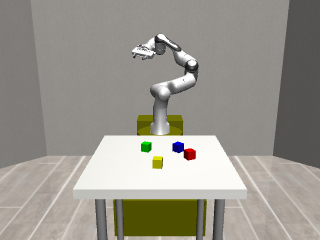

Goal qpos


""

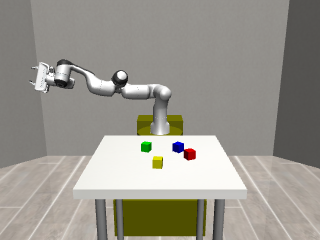

Planner 1 :: Find trajectory with length 70 in time 2.0867581367492676.
Planner 2 :: Find trajectory with length 140 in time 2.006594657897949.
Planner 3 :: Find trajectory with length 610 in time 2.0354440212249756.


In [48]:
def test_rrt_star_planner():
    init_qpos = None
    goal_qpos = None
    sampler = Sampler(
        model=MODEL,
        body_ids=get_body_ids(MODEL, eef="hand"),
    )
    collision_checker = CollisionChecker(
        model=MODEL,
        body_ids=get_body_ids(MODEL, eef="hand"),
    )

    while True:
        init_qpos = sampler()
        if not collision_checker(init_qpos):
            break
    while True:
        goal_qpos = sampler()
        if not collision_checker(goal_qpos):
            break

    print("Start qpos")
    media.show_image(get_image_of_pos(init_qpos))

    print("Goal qpos")
    media.show_image(get_image_of_pos(goal_qpos))

    # Initialize the RRT* planner
    planner_1 = RRTStarPlanner(gamma=0.5, eta=0.1, epsilon=0.1)
    planner_2 = RRTStarPlanner(gamma=0.5, eta=0.05, epsilon=0.1)

    # ETA가 작으면 더 정교한 path를 찾을 수 있다.
    planner_3 = RRTStarPlanner(gamma=0.5, eta=0.01, epsilon=0.1)

    planners = [planner_1, planner_2, planner_3]
    paths = []
    for index, rrt_planner in enumerate(planners):
        start = time.time()
        rrt_planner(
            sampler,
            collision_checker,
            init_qpos,
            goal_qpos,
            max_iter=10000,
            threshold=0.05,
        )
        end = time.time()
        if path := rrt_planner.path:
            print(
                f"Planner {index+1} :: Find trajectory with length {len(path)} in time {end - start}."
            )
            paths.append(path)
        else:
            print(
                f"Planner {index+1} :: Failed to find trajectory. time: {end - start}"
            )

    for path in paths:
        frames = [get_image_of_pos(path[0]) for _ in range(len(path) // 10)]
        frames = frames + [get_image_of_pos(pos) for pos in path]
        frames = frames + [get_image_of_pos(path[-1]) for _ in range(len(path) // 10)]

        media.show_video(frames, fps=len(path) / 5)


test_rrt_star_planner()

The video above was *__not__* controlled using a PID controller.

# 7.5 `Cartesian Planner`


### **Specifications**:

#### 1. **Class Definition**:
- **Class Name**: `CartesianPlanner`

#### 2. **Constructor Parameters**:
- `damping`: A damping factor used in the `Damped Least Squares (DLS)` method for `inverse kinematics` (default: `0.01`).
- `goal_tolerance`: Tolerance for considering the goal position reached (default: `0.01`).

#### 3. **Methods**:
- `__init__(self, damping: float = 0.01, goal_tolerance: float = 0.01)`: Initializes the planner with the given parameters.
- `__call__(self, sampler: Sampler, collision: CollisionChecker, kinematics: Kinematics, init_qpos: npt.NDArray, goal_pos: npt.NDArray, goal_rot: npt.NDArray, eef_id: int = None, resolution: int = 1, n_step: int = 100, max_iter: int = 10, threshold: float = 1e-12)`: Plans a path from the initial configuration to the goal pose.
- `generate_waypoints(self, init_pos, init_rot, goal_pos, goal_rot, n_step, is_slerp=False) -> list[tuple[npt.NDArray, npt.NDArray]]`: Generates waypoints from the initial pose to the goal pose.

#### 4. **Functional Requirements**:
- The planner should generate waypoints from the initial pose to the goal pose.
- It should use inverse kinematics to move the end-effector along the waypoints.
- It should check for collisions and ensure the path is collision-free.
- It should stop if the goal pose is reached within the specified tolerance.

In [49]:
def get_quaternion_from_matrix(R):
    # Ensure the input is a proper rotation matrix
    assert R.shape == (3, 3)

    # Calculate the trace of the matrix
    trace = np.trace(R)

    if trace > 0:
        s = 2.0 * np.sqrt(trace + 1.0)
        w = 0.25 * s
        x = (R[2, 1] - R[1, 2]) / s
        y = (R[0, 2] - R[2, 0]) / s
        z = (R[1, 0] - R[0, 1]) / s
    elif (R[0, 0] > R[1, 1]) and (R[0, 0] > R[2, 2]):
        s = 2.0 * np.sqrt(1.0 + R[0, 0] - R[1, 1] - R[2, 2])
        w = (R[2, 1] - R[1, 2]) / s
        x = 0.25 * s
        y = (R[0, 1] + R[1, 0]) / s
        z = (R[0, 2] + R[2, 0]) / s
    elif R[1, 1] > R[2, 2]:
        s = 2.0 * np.sqrt(1.0 + R[1, 1] - R[0, 0] - R[2, 2])
        w = (R[0, 2] - R[2, 0]) / s
        x = (R[0, 1] + R[1, 0]) / s
        y = 0.25 * s
        z = (R[1, 2] + R[2, 1]) / s
    else:
        s = 2.0 * np.sqrt(1.0 + R[2, 2] - R[0, 0] - R[1, 1])
        w = (R[1, 0] - R[0, 1]) / s
        x = (R[0, 2] + R[2, 0]) / s
        y = (R[1, 2] + R[2, 1]) / s
        z = 0.25 * s

    return np.array([w, x, y, z])


def get_matrix_from_quaternion(quat):
    w, x, y, z = quat
    R = np.array(
        [
            [2 * (w**2 + x**2) - 1, 2 * (x * y - w * z), 2 * (x * z + w * y)],
            [2 * (x * y + w * z), 2 * (w**2 + y**2) - 1, 2 * (y * z - w * x)],
            [2 * (x * z - w * y), 2 * (y * z + w * x), 2 * (w**2 + z**2) - 1],
        ]
    )
    return R


def get_linear_interpoation(postionA, postionB, step):
    postionA = np.asarray(postionA)
    postionB = np.asarray(postionB)
    return postionB * step + postionA * (1 - step)


def get_quaternion_inverse(quaternion):
    q = np.array(quaternion, dtype=np.float64, copy=True)
    np.negative(q[1:], q[1:])
    return q / np.dot(q, q)


def get_quaternion_slerp(qA, qB, t):
    if isinstance(qA, (np.ndarray, list)) and isinstance(qB, (np.ndarray, list)):
        qA = np.asarray(qA)
        qB = np.asarray(qB)
        if qA.shape != (4,):  # quaternion
            raise ValueError("Expecting the shape of the orientation to be (4,)")
        if qB.shape == (0,):
            qB = np.asarray([1.0, 0.0, 0.0, 0.0])

        a = qB * get_quaternion_inverse(qA)
        result = np.sign(a) * (np.abs(a)) ** t * qA
        return result

In [50]:
class CartesianPlanner:
    """
    Cartesian planner

    forward (theta) -> (x, y, z, qw, qx, qy, qz) -> inverse (x, y, z, qw, qx, qy, qz) -> (theta)

    ```md
    P0 --> delta P --> Pt
    R0 --> delta R --> Rt
    ```

    Args:
        damping (`float`): damping factor for the damped least squares
        goal_tolerance (`float`): tolerance for the goal position
    """

    def __init__(self, damping: float = 0.01, goal_tolerance: float = 0.01):
        """
        Initialize the Cartesian planner

        Args:
            damping (`float`): damping factor for the damped least squares
            goal_tolerance (`float`): tolerance for the goal position
        """
        self.damping = damping
        self.goal_tolerance = goal_tolerance
        self.path = []

    def __call__(
        self,
        sampler: Sampler,
        collision: CollisionChecker,
        kinematics: Kinematics,
        init_qpos: npt.NDArray,
        goal_pos: npt.NDArray,
        goal_rot: npt.NDArray,
        eef_id: int = None,
        resolution: int = 1,
        n_step: int = 100,
        max_iter: int = 10,
        threshold: float = 1e-12,
    ) -> None:
        """
        Args:
            sampler (`Sampler`): sampler for the joint positions
            collision (`CollisionChecker`): collision checker
            kinematics (`Kinematics`): kinematics solver
            init_qpos (`npt.NDArray`): initial joint positions
            goal_pos (`npt.NDArray`): goal position
            goal_rot (`npt.NDArray`): goal rotation
            eef_id (`int`): end-effector body id
            resolution (`int`): resolution for the path
            n_step (`int`): number of steps(point count) for the waypoints path, !! 많을수록 상세한 path가 생성된다.
            max_iter (`int`): maximum number of Jacobian computation iterations
            threshold (`float`): threshold for the error
        """
        self.path = []
        init_pos, _, init_rot = kinematics.forward(init_qpos, eef_id)

        # 갈 길에 대한 points 생성
        waypoints = self.generate_waypoints(
            init_pos, init_rot, goal_pos, goal_rot, n_step
        )

        nv = kinematics.model.nv
        body_ids = kinematics.body_ids
        joint_ids = kinematics.model.body_jntadr[body_ids]
        joint_ids = [id for id in joint_ids if id != -1]

        # qpos, qvel address
        # qpos = joint position, qvel = joint velocity
        qpos_adrs = kinematics.model.jnt_qposadr[joint_ids]
        qvel_adrs = kinematics.model.jnt_dofadr[joint_ids]

        # Initialize the Jacobian data
        jac_data = mujoco.MjData(kinematics.model)
        jac_data.qpos[:] = collision.model_data.qpos.copy()

        jacp = np.zeros((3, nv))
        jacr = np.zeros((3, nv))

        DOF = kinematics.get_total_dof_of_body_ids(body_ids)

        collision_flag = False

        # Jacobian computation using damped-least-squares
        damping = self.damping

        for _ in range(max_iter):
            current_qpos = init_qpos.copy()
            joint_path = [current_qpos]
            jac_data.qpos[qpos_adrs] = current_qpos
            mujoco.mj_forward(kinematics.model, jac_data)
            current_pos = jac_data.body(body_ids[-1]).xpos.copy()
            current_rot = jac_data.body(body_ids[-1]).xmat.copy().reshape([3, 3])

            for step, (pos, rot) in enumerate(waypoints):
                # 1. 현재 위치와 목표 위치의 차이를 계산
                err_pose = calc_pose_error(
                    pos, rot, current_pos, current_rot, threshold
                )

                # 2. Jacobian 계산 -> mujoco API -> jacp, jacr 저장
                mujoco.mj_jac(
                    kinematics.model, jac_data, jacp, jacr, current_pos, body_ids[-1]
                )
                J = np.vstack(
                    [
                        jacp[:, qvel_adrs[0] : qvel_adrs[0] + DOF],
                        jacr[:, qvel_adrs[0] : qvel_adrs[0] + DOF],
                    ]
                )
                J_dls = np.dot(
                    J.T, np.linalg.inv(np.dot(J, J.T) + damping**2 * np.identity(6))
                )
                # 3. dq 계산 -> dq = J_dls * err_pose
                dq = np.dot(J_dls, err_pose)
                # 4. dq를 현재 위치에 더한다.
                current_qpos = current_qpos + dq.reshape([-1])

                # 5. 현재 위치가 valid한지 확인
                if collision(current_qpos):
                    # 충돌 path라면 불가능
                    collision_flag = True
                    break

                # 6. 충돌 없는 현재 위치를 mujoco에 업데이트
                jac_data.qpos[qpos_adrs] = current_qpos

                # 7. mujoco forward -> 현재 위치와 자세를 업데이트
                mujoco.mj_forward(kinematics.model, jac_data)

                # 8. 현재 위치, 자세 가져옴
                current_pos = jac_data.body(body_ids[-1]).xpos.copy()
                current_rot = jac_data.body(body_ids[-1]).xmat.copy().reshape([3, 3])

                # 9. 현재 위치를 path에 추가
                if current_qpos in sampler:
                    # resolution에 따라 path를 추가
                    if step % (1 / resolution) == 0 or step == len(waypoints) - 1:
                        joint_path.append(current_qpos)
            else:
                err = np.linalg.norm(goal_pos - current_pos)
                if err < self.goal_tolerance:
                    break
            if collision_flag:
                joint_path = []
                break
        else:
            joint_path = []
        self.path = joint_path

    def generate_waypoints(
        self,
        init_pos,
        init_rot,
        goal_pos,
        goal_rot,
        n_step,
        is_slerp=False,
    ) -> list[tuple[npt.NDArray, npt.NDArray]]:
        """
        Generate waypoints for the path

        Args:
            init_pos (`npt.NDArray`): initial position
            init_rot (`npt.NDArray`): initial rotation
            goal_pos (`npt.NDArray`): goal position
            goal_rot (`npt.NDArray`): goal rotation
            n_step (`int`): number of waypoints steps
            is_slerp (`bool`): flag to use slerp
        """
        waypoints = []
        if is_slerp:
            init_ori = get_quaternion_from_matrix(init_rot)
            goal_ori = get_quaternion_from_matrix(goal_rot)

        for step in range(1, n_step + 1):
            delta_t = step / n_step
            pos = get_linear_interpoation(init_pos, goal_pos, delta_t)
            rot = init_rot
            if is_slerp:
                quat = get_quaternion_slerp(init_ori, goal_ori, delta_t)
                rot = get_matrix_from_quaternion(quat)
            waypoints.append((pos, rot))
        return waypoints

Init qpos


""

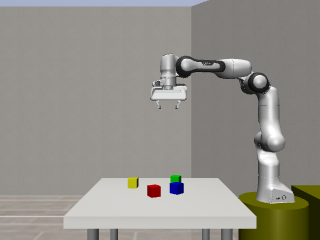

2.7627261656669226e-06
4.2705618513681985e-07
3.577702715365005e-07
Path to move X-axis :: Find trajectory with length 101 in time 0.030965805053710938.
Path to move Y-axis :: Find trajectory with length 101 in time 0.016037940979003906.
Path to move Z-axis :: Find trajectory with length 101 in time 0.015724897384643555.


In [51]:
def test_cartesian_planner():
    # 1. Reset the model
    mujoco.mj_resetDataKeyframe(MODEL, MODEL_DATA, 0)
    mujoco.mj_forward(MODEL, MODEL_DATA)

    # 2. Get the body ids
    body_ids = get_body_ids(MODEL, eef="hand")
    # 3. Get the qpos address
    qpose_adress = get_qpos_adrs(MODEL, body_ids)
    # 4. Get the initial qpos
    initial_qpos = MODEL_DATA.qpos[qpose_adress]
    print("Init qpos")
    media.show_image(get_image_of_pos(initial_qpos, "sideview"))

    # 5. Initialize the kinematics, sampler, collision checker
    kinematics = Kinematics(MODEL, body_ids)
    sampler = Sampler(MODEL, body_ids)
    collision_checker = CollisionChecker(MODEL, body_ids)

    # 6. Get the cartesian goals
    cartesian_goals = []
    for axis in range(3):
        goal_pos, _, goal_rot = kinematics.forward(initial_qpos)
        goal_pos[axis] = goal_pos[axis] - 0.1
        cartesian_goal_qpos = kinematics.inverse(initial_qpos, goal_pos, goal_rot)
        if cartesian_goal_qpos is not None and cartesian_goal_qpos in sampler:
            cartesian_goals.append((goal_pos, goal_rot))

    # 7. Initialize the cartesian planner
    cartesian_planner = CartesianPlanner()

    founded_paths = []
    axis_name = ["X", "Y", "Z"]

    for index, (pos, rot) in enumerate(cartesian_goals):
        start = time.time()
        cartesian_planner(
            sampler,
            collision_checker,
            kinematics,
            initial_qpos,
            pos,
            rot,
            n_step=100,
            resolution=2,
        )
        end = time.time()
        if path := cartesian_planner.path:
            print(
                f"Path to move {axis_name[index]}-axis :: Find trajectory with length {len(path)} in time {end - start}."
            )
            founded_paths.append(path)
        else:
            print(
                f"Path to move {axis_name[index]}-axis :: Failed to find trajectory. time: {end - start}"
            )

    # 8. Show the path, result as video
    views = ["sideview", "frontview", "frontview"]

    for path, view in zip(founded_paths, views):
        frames = [get_image_of_pos(path[0], view) for _ in range(len(path) // 10)]
        frames = frames + [get_image_of_pos(pos, view) for pos in path]
        frames = frames + [
            get_image_of_pos(path[-1], view) for _ in range(len(path) // 10)
        ]

        media.show_video(frames, fps=len(path) / 5)


test_cartesian_planner()

The video above was *__not__* controlled using a PID controller.

# 8. Object Grasp Planning

# Problem 1. [10pt] Find an object's pose in MuJoCo environment

In a MuJoCo simulation environment, you often need to retrieve the positions and orientations of various objects (bodies) within the simulation. This information is crucial for tasks such as control, visualization, and analysis. Given a list of body names, write a Python function that:

Retrieves the body IDs for the given body names.
Extracts the positions and orientations (quaternions) of these bodies.
Stores and returns this information in a dictionary.

1. `get_body_names(model)`: Retrieves and returns a list of all body names in the MuJoCo model.
2. `get_body_poses(model, data, body_names)`: Takes a list of body names and returns a dictionary with their positions and orientations.

In [52]:
from typing import Literal
import mujoco


def get_body_names(model: mujoco.MjModel) -> list[str]:
    """
    Retrieve all body names from the MuJoCo model.

    Parameters:
        model: MuJoCo model object.

    Returns:
        List of body names.
    """
    body_names: list[str] = []
    for i in range(model.nbody):
        body_name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_BODY, i)
        if body_name:
            body_names.append(body_name)
    return body_names


def get_body_poses(
    model: mujoco.MjModel, data: mujoco.MjData, body_names: list[str]
) -> dict[
    str,
    dict[
        Literal[
            "position",
            "orientation",
        ],
        npt.NDArray,
    ],
]:
    """
    Retrieve the positions and orientations of specified bodies.

    Parameters:
        model: MuJoCo model object.
        data: MuJoCo data object.
        body_names: List of body names to retrieve poses for.

    Returns:
        Dictionary with body names as keys and their poses as values.
    """
    poses: dict[
        str,
        dict[Literal["position", "orientation"], npt.NDArray],
    ] = {}
    for body_name in body_names:
        body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, body_name)
        if body_id != -1:
            position = data.xpos[body_id]  # world position of the body
            orientation = data.xquat[body_id]  # orientation of the body in quaternions
            poses[body_name] = {
                "position": position,
                "orientation": orientation,
            }

    return poses

## Update model for final test

In [53]:
# Replace model
# Initialize the MuJoCo model and data
MODEL_PATH = (
    "./panda_mjcf/panda_4cube.xml"  # Provide the path to your MuJoCo model file
)
MODEL = mujoco.MjModel.from_xml_path(MODEL_PATH)
MODEL_DATA = mujoco.MjData(MODEL)

# Reset the data to the initial keyframe and forward the simulation to update the data
mujoco.mj_resetDataKeyframe(MODEL, MODEL_DATA, 0)
mujoco.mj_forward(MODEL, MODEL_DATA)

In [54]:
def test_problem1():
    # Retrieve all body names to potentially modify what is returned based on what is present in the model
    all_body_names = get_body_names(MODEL)

    print("All body names:")
    print(all_body_names)
    # Get the poses of the specified bodies
    initial_gripper_pose = get_body_poses(MODEL, MODEL_DATA, all_body_names)

    print(initial_gripper_pose)
    # Print the poses
    for body_name, pose in initial_gripper_pose.items():
        print(f"Pose of {body_name}:")
        print(f"  Position: {pose['position']}")
        print(f"  Orientation (quaternion): {pose['orientation']}")


test_problem1()

All body names:
['world', 'table', 'red_cube', 'blue_cube', 'green_cube', 'yellow_cube', 'robot_fixed', 'mount_base', 'mount0_controller_box', 'mount_pedestal_feet', 'mount_torso', 'mount_pedestal', 'link0', 'link1', 'link2', 'link3', 'link4', 'link5', 'link6', 'link7', 'hand', 'grasp_site', 'left_finger', 'right_finger']
{'world': {'position': array([0., 0., 0.]), 'orientation': array([1., 0., 0., 0.])}, 'table': {'position': array([0.   , 0.   , 0.775]), 'orientation': array([1., 0., 0., 0.])}, 'red_cube': {'position': array([0.03 , 0.172, 0.85 ]), 'orientation': array([0.973, 0.   , 0.   , 0.23 ])}, 'blue_cube': {'position': array([-0.086,  0.113,  0.85 ]), 'orientation': array([0.92 , 0.   , 0.   , 0.392])}, 'green_cube': {'position': array([-0.093, -0.085,  0.85 ]), 'orientation': array([0.825, 0.   , 0.   , 0.565])}, 'yellow_cube': {'position': array([ 0.149, -0.012,  0.85 ]), 'orientation': array([0.747, 0.   , 0.   , 0.665])}, 'robot_fixed': {'position': array([-0.6 ,  0.  ,  0

# Problem 2. [20pt] Compute grasp poses to grasp an object in MuJoCo environment

In this problem, you are required to compute the necessary poses for a robotic gripper to grasp an object in a MuJoCo simulation. The solution will involve:

1. Computing the grasp pose for the gripper.
2. Computing the pre-grasp and post-grasp poses.
3. Solving the inverse kinematics for the pre-grasp pose.

### A. Pre-Grasp Pose
The pre-grasp pose is an intermediate pose where the gripper is positioned slightly above the object. This pose is used to ensure that the gripper can move down smoothly and accurately to the grasp pose. It helps avoid collisions and provides a controlled approach to grasping.

### B. Post-Grasp Pose
The post-grasp pose is the pose that the gripper assumes immediately after successfully grasping the object. This pose is used to lift the object slightly to ensure it is securely held before any further manipulation or movement.

### 본문제 = Pre-grasp ~= Post-grasp grasp

In [55]:
def compute_gripper_pose_for_grasping_cube(
    cube_pos, cube_quat, gripper_quat, height_above_cube=0.12
):
    """
    Compute the gripper pose for grasping a cube.

    Parameters:
        cube_pos (array): Position of the cube [x, y, z].
        cube_quat (array): Orientation of the cube in quaternion [w, x, y, z].
        gripper_quat (array): Orientation of the gripper in quaternion [w, x, y, z].
        height_above_cube (float): Height above the cube for the gripper.

    Returns:
        tuple: Final gripper position, quaternion, and rotation matrix.
    """
    # Compute the new gripper position for grasping
    gripper_position = cube_pos.copy()
    # Adjust to a suitable height above the cube base
    gripper_position[2] += height_above_cube

    # Compute the relative rotation needed to align the gripper with the cube's orientation
    gripper_quaternion = gripper_quat.copy()
    rotation_matrix = get_matrix_from_quaternion(gripper_quaternion)

    # Combine the gripper's downward orientation with the cube's orientation
    # to align the gripper with the cube's orientation
    gripper_alignment = np.dot(get_matrix_from_quaternion(cube_quat), rotation_matrix)

    # Return the final gripper position, quaternion, and rotation matrix
    return gripper_position, gripper_quaternion, gripper_alignment

3.2523701325882594e-08
Gripper Pose:
  Position: [0.03  0.172 0.97 ]
  Orientation (quaternion): [-0.     0.707  0.707  0.   ]
Pre Gripper Pose:
  Position: [0.03  0.172 1.   ]
  Orientation (quaternion): [-0.     0.707  0.707  0.   ]


""

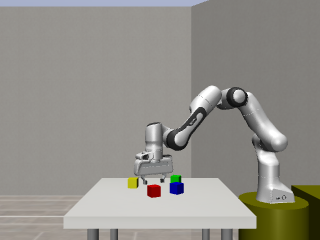

""

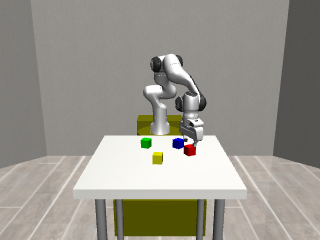

In [56]:
def test_problem2():
    body_poses = get_body_poses(
        MODEL,
        MODEL_DATA,
        get_body_names(MODEL),
    )

    # Retrieve the cube and gripper positions and orientations from the body poses
    cube_position = body_poses["red_cube"]["position"]
    cube_orientation = body_poses["red_cube"]["orientation"]

    hand_position = body_poses["hand"]["position"]
    hand_orientation = body_poses["hand"]["orientation"]

    # Compute the gripper pose for grasping the cube
    gripper_position, gripper_orientation, gripper_rot = (
        compute_gripper_pose_for_grasping_cube(
            cube_position, cube_orientation, hand_orientation
        )
    )

    # Compute the pre-grasp pose (slightly above the final grasp pose)
    pre_gripper_position, pre_gripper_orientation, pre_gripper_rot = (
        copy.deepcopy(gripper_position),
        copy.deepcopy(gripper_orientation),
        copy.deepcopy(gripper_rot),
    )
    pre_gripper_position[2] += 0.03

    # Reset the simulation data and forward the simulation to update the state
    mujoco.mj_resetDataKeyframe(MODEL, MODEL_DATA, 0)
    mujoco.mj_forward(MODEL, MODEL_DATA)

    # Initialize the kinematics solver with the MODEL and body IDs
    body_ids = get_body_ids(MODEL, eef="hand")

    # Sample the current joint positions
    qpos_adress = get_qpos_adrs(MODEL, body_ids)
    sample = MODEL_DATA.qpos[qpos_adress]

    # Solve the inverse kinematics for the pre-grasp pose
    kinematics = Kinematics(MODEL, body_ids)
    pre_grasp_qpos = kinematics.inverse(
        sample,
        pre_gripper_position,
        pre_gripper_rot,
        max_iter=200,
    )

    # Print the computed gripper poses
    print("Gripper Pose:")
    print(f"  Position: {gripper_position}")
    print(f"  Orientation (quaternion): {gripper_orientation}")
    print("Pre Gripper Pose:")
    print(f"  Position: {pre_gripper_position}")
    print(f"  Orientation (quaternion): {pre_gripper_orientation}")

    # Visualize the pre-grasp pose from different camera views
    views = ["sideview", "frontview"]
    for view in views:
        media.show_image(get_image_of_pos(pre_grasp_qpos, view))


test_problem2()

# Problem 3. [30pt] Find a path from an initial pose to the grasp pose

In this problem, you are required to plan a path to execute the grasping.

## Path Planning Recommendations:

> 2번을 통해 유도한 `pre-grasp` 위치를 통해 `RRT*` 를 호출한다.

#### 1. From the `initial` -> `pre-grasp` pose: Use `RRT*`(Rapidly-exploring Random Tree) for path planning.
#### 2. From the pre-grasp pose to the grasp pose: Use `Cartesian planning` for a `straight-line` approach.
#### 3. From the grasp pose to the post-grasp pose: Reverse the `Cartesian plan`.
#### 4. From the post-grasp pose to the initial pose: Reverse the `RRT*` plan.

In [57]:
def get_grasp_path(
    model: mujoco.MjModel,
    model_data: mujoco.MjData,
    height_above_cube: float = 0.12,
    rrt_start_max_iter: int = 100,
    rr_start_threshold: float = 0.05,
    rrt_start_gamma: float = 0.5,
    rrt_start_eta: float = 0.1,
    rrt_start_epsilon: float = 0.1,
    cartesian_dls_damping: float = 0.01,
    cartesian_goal_tolerance: float = 0.01,
    cartesian_resolution: int = 1,
    cartesian_max_iter: int = 10,
    cartesian_threshold: float = 1e-12,
    cartesian_n_step: int = 500,
    log: bool = False,
) -> list[npt.NDArray]:
    """
    Args:
        model: MuJoCo model object
        model_data: MuJoCo data object
        height_above_cube: Height above the cube for the gripper
        rrt_start_max_iter: Maximum number of iterations
        rr_start_threshold: Goal threshold
        rrt_start_gamma: Gamma value, the search radius
        rrt_start_eta: Eta value, lower eta value for more detailed path
        rrt_start_epsilon: Epsilon value, the probability of choosing the goal
        cartesian_dls_damping: Damping factor for the damped least squares method
        cartesian_goal_tolerance: Goal tolerance for the Cartesian planner
        cartesian_resolution: Resolution for the Cartesian planner
        cartesian_max_iter: Maximum number of iterations for the Cartesian planner
        cartesian_threshold: Threshold for the Cartesian planner
        cartesian_n_step: Number of steps for the Cartesian planner
        log: Flag to enable logging
    """
    body_poses = get_body_poses(
        MODEL,
        model_data,
        get_body_names(MODEL),
    )

    # Retrieve the cube and gripper positions and orientations from the body poses
    cube_position = body_poses["red_cube"]["position"]
    cube_orientation = body_poses["red_cube"]["orientation"]

    hand_position = body_poses["hand"]["position"]
    hand_orientation = body_poses["hand"]["orientation"]

    # Compute the gripper pose for grasping the cube
    gripper_position, gripper_orientation, gripper_rot = (
        compute_gripper_pose_for_grasping_cube(
            cube_position, cube_orientation, hand_orientation
        )
    )

    # Compute the pre-grasp pose (slightly above the final grasp pose)
    pre_gripper_position, pre_gripper_orientation, pre_gripper_rot = (
        copy.deepcopy(gripper_position),
        copy.deepcopy(gripper_orientation),
        copy.deepcopy(gripper_rot),
    )
    pre_gripper_position[2] += height_above_cube

    # Reset the simulation data and forward the simulation to update the state
    mujoco.mj_resetDataKeyframe(model, model_data, 0)
    mujoco.mj_forward(model, model_data)

    # Initialize the kinematics solver with the MODEL and body IDs
    body_ids = get_body_ids(model, eef="hand")

    # Sample the initial joint positions, reset already done so current pos is the initial pos
    qpos_adress = get_qpos_adrs(model, body_ids)
    initial_qpos = model_data.qpos[qpos_adress]

    # Solve the inverse kinematics for the pre-grasp pose
    kinematics = Kinematics(model, body_ids)
    pre_grasp_qpos = kinematics.inverse(
        initial_qpos,
        pre_gripper_position,
        pre_gripper_rot,
        max_iter=1000,
    )
    collision_checker = CollisionChecker(model, body_ids)
    sampler = Sampler(model, body_ids)

    # Initialize Planners
    rrtstar_planner = RRTStarPlanner(
        gamma=rrt_start_gamma,
        eta=rrt_start_eta,
        epsilon=rrt_start_epsilon,
    )
    cartesian_planner = CartesianPlanner(
        damping=cartesian_dls_damping,
        goal_tolerance=cartesian_goal_tolerance,
    )

    # Compute pre-grasp pose based on previously defined function
    # Assume gripper_position, gripper_orientation from Problem 2 are known and correct

    # Plan path from initial to pre-grasp pose using RRT*
    rrtstar_planner(
        sampler=sampler,
        collision=collision_checker,
        init_qpos=initial_qpos,
        goal_qpos=pre_grasp_qpos,
        max_iter=rrt_start_max_iter,
        threshold=rr_start_threshold,
    )

    # Cartesian planning from pre-grasp to grasp pose
    # Assuming that Cartesian planning also handles orientations
    cartesian_planner(
        sampler=sampler,
        collision=collision_checker,
        kinematics=kinematics,
        init_qpos=pre_grasp_qpos,  # pre-grasp pose -> goal gripper pos, rot
        goal_pos=gripper_position,  # Final grasp position
        goal_rot=gripper_rot,  # Final grasp orientation
        resolution=cartesian_resolution,
        n_step=cartesian_n_step,
        max_iter=cartesian_max_iter,
        threshold=cartesian_threshold,
    )

    # Collect the full path
    path_rrt = rrtstar_planner.path
    path_cartesian = cartesian_planner.path

    # Full path including pre/post grasp and return to initial
    full_planned_path: list[npt.NDArray] = (
        # Initial waiting pose
        [initial_qpos] * 10
        + path_rrt
        + path_cartesian
        + [pre_grasp_qpos] * 5  # Pre-grasp pose
        + list(reversed(path_cartesian))
        + list(reversed(path_rrt))
        + [initial_qpos] * 10
        # # Return to initial pose
    )

    if log:
        # Print or visualize the path
        print("Full Planned Path: total steps", len(full_planned_path))
        for step in full_planned_path:
            print(step)

    return full_planned_path


test_path = get_grasp_path(MODEL, MODEL_DATA, log=True)

3.7731920767166345e-06
Full Planned Path: total steps 1027
[ 0.     0.     0.    -1.571  0.     1.571 -0.785]
[ 0.     0.     0.    -1.571  0.     1.571 -0.785]
[ 0.     0.     0.    -1.571  0.     1.571 -0.785]
[ 0.     0.     0.    -1.571  0.     1.571 -0.785]
[ 0.     0.     0.    -1.571  0.     1.571 -0.785]
[ 0.     0.     0.    -1.571  0.     1.571 -0.785]
[ 0.     0.     0.    -1.571  0.     1.571 -0.785]
[ 0.     0.     0.    -1.571  0.     1.571 -0.785]
[ 0.     0.     0.    -1.571  0.     1.571 -0.785]
[ 0.     0.     0.    -1.571  0.     1.571 -0.785]
[ 0.145  0.406  0.138 -1.756 -0.065  2.158 -1.407]
[ 0.145  0.406  0.138 -1.756 -0.065  2.158 -1.407]
[ 0.145  0.407  0.138 -1.756 -0.065  2.159 -1.407]
[ 0.145  0.407  0.138 -1.756 -0.065  2.159 -1.406]
[ 0.145  0.407  0.137 -1.757 -0.065  2.16  -1.406]
[ 0.145  0.408  0.137 -1.757 -0.065  2.16  -1.406]
[ 0.145  0.408  0.137 -1.757 -0.065  2.161 -1.406]
[ 0.145  0.408  0.137 -1.757 -0.065  2.161 -1.406]
[ 0.145  0.408  0.137 -

# Problem 4. [40pt] Control a robot to follow the paths.

You will use path planning algorithms and a `PID` controller to simulate the robot's movements along these paths. The solution involves:

### Initializing the robot and controller.
### Following the paths.
### Simulating and visualizing the robot's movements.

In [58]:
def simulate_path(
    model: mujoco.MjModel,
    model_data: mujoco.MjData,
    path: list[npt.NDArray],
    controller: PIDController,
    error_threshold: float = 0.07,
    frame_rate: int = 15,
):
    """
    Simulate the gripper following the planned path.

    Parameters:
        model: MuJoCo model object.
        data: MuJoCo data object.
        path: List of waypoints (joint configurations).
        controller: PID controller object.
    """
    # Initialize a list to store frames for the video
    frames = []

    joint_ids, actuator_addresses = get_joint_actuator_ids_adress(model)
    qpos_adrs = get_joint_qpos_addresses(model, joint_ids)

    # Iterate through each waypoint in the path
    for qpos_idx, curr_qpos in enumerate(path):
        # Reset the controller with the current simulation time
        controller.reset(model_data.time)
        # Set the target position for the controller
        controller.x_trgt = curr_qpos

        while True:
            # Copy the current joint positions
            x_curr = model_data.qpos[qpos_adrs].copy()

            # Update the controller with the current positions and time
            controller.update(x_curr, model_data.time)

            # Set the control inputs for the actuators
            model_data.ctrl[actuator_addresses] = controller.out()

            # Step the simulation forward
            mujoco.mj_step(model, model_data)

            # Render and save frames
            if len(frames) < model_data.time * frame_rate:
                renderer.update_scene(model_data, camera="sideview")
                pixels = renderer.render()
                frames.append(pixels)

            # Break if the current error is small enough
            if np.sum(np.abs(controller.err_curr)) < error_threshold:
                print(f"Reached waypoint calculated: {qpos_idx + 1}/{len(path)}")
                break

    return frames


def test_problem5():
    actuator_address = get_joint_actuator_ids_adress(MODEL)[1]

    # 1. Define a controller
    pid_controller = PIDController(
        k_p=1000,
        k_i=0.5,
        k_d=50,
        dim=7,
        out_min=MODEL.actuator_ctrlrange[actuator_address, 0],
        out_max=MODEL.actuator_ctrlrange[actuator_address, 1],
    )

    # 2. Get grasp path
    grasp_path = get_grasp_path(
        MODEL,
        MODEL_DATA,
        rr_start_threshold=0.001,
        rrt_start_max_iter=1000,
        rrt_start_eta=0.01,
    )
    # 3. Simulate paths and collect frames
    frames = simulate_path(
        MODEL,
        MODEL_DATA,
        grasp_path,
        pid_controller,
        error_threshold=0.07,
        frame_rate=5,
    )

    FRAME_RATE = 60
    # 4. Display video.
    media.show_video(frames, fps=FRAME_RATE)


test_problem5()

2.5565426173349498e-06
Reached waypoint calculated: 1/1241
Reached waypoint calculated: 2/1241
Reached waypoint calculated: 3/1241
Reached waypoint calculated: 4/1241
Reached waypoint calculated: 5/1241
Reached waypoint calculated: 6/1241
Reached waypoint calculated: 7/1241
Reached waypoint calculated: 8/1241
Reached waypoint calculated: 9/1241
Reached waypoint calculated: 10/1241
Reached waypoint calculated: 11/1241
Reached waypoint calculated: 12/1241
Reached waypoint calculated: 13/1241
Reached waypoint calculated: 14/1241
Reached waypoint calculated: 15/1241
Reached waypoint calculated: 16/1241
Reached waypoint calculated: 17/1241
Reached waypoint calculated: 18/1241
Reached waypoint calculated: 19/1241
Reached waypoint calculated: 20/1241
Reached waypoint calculated: 21/1241
Reached waypoint calculated: 22/1241
Reached waypoint calculated: 23/1241
Reached waypoint calculated: 24/1241
Reached waypoint calculated: 25/1241
Reached waypoint calculated: 26/1241
Reached waypoint calcula